# Generating FBM Samples wrt Time, using FBM library

* We can observe that increasing hurst parameter, we get smoother relaisations of motion.

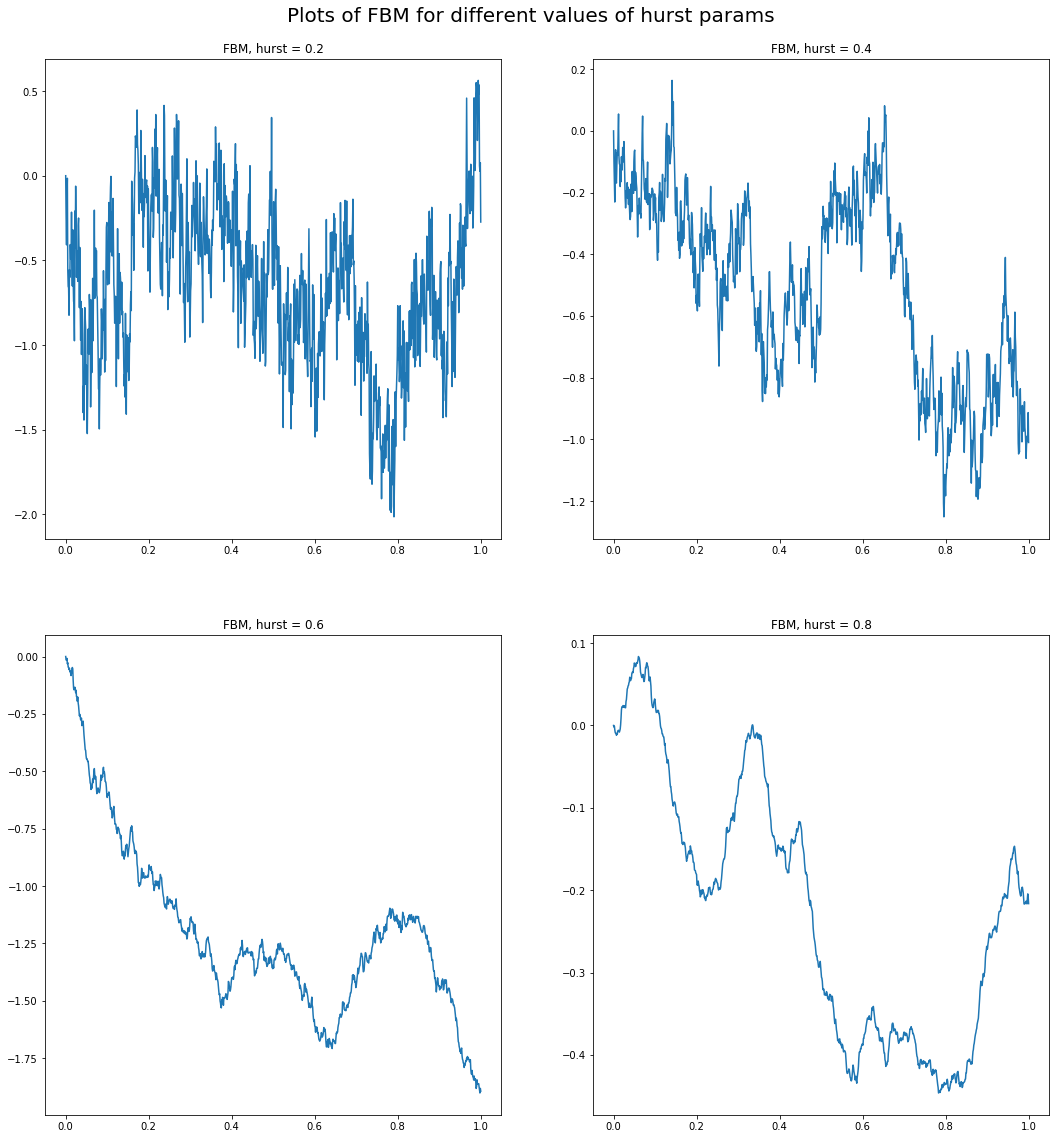

In [34]:
%matplotlib inline

from fbm import FBM
import matplotlib.pyplot as plt
import numpy as np
from scipy.fftpack import fft, ifft, fftfreq

def plt_fbm(h_param,num_samp,subplot_index=111):
    f = FBM(n=num_samp, hurst=h_param, length=1, method='daviesharte')
    # Generate a fBm realization
    fbm_sample = f.fbm()

    # Get the times associated with the fBm
    t_values = f.times()
    
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FBM, hurst = "+str(h_param))
    ax.plot(t_values,fbm_sample)
    #print(t_values)
    return fbm_sample

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
fbm_samps=[]
plt.suptitle("Plots of FBM for different values of hurst params",fontsize=20)
num_pts=1000
t_samp=np.linspace(0,1,num_pts+1)
fbm_samps.append(plt_fbm(0.2,num_pts,221))
fbm_samps.append(plt_fbm(0.4,num_pts,222))
fbm_samps.append(plt_fbm(0.6,num_pts,223))
fbm_samps.append(plt_fbm(0.8,num_pts,224))
plt.show()

# Plotting the FFT of FBM motion as well

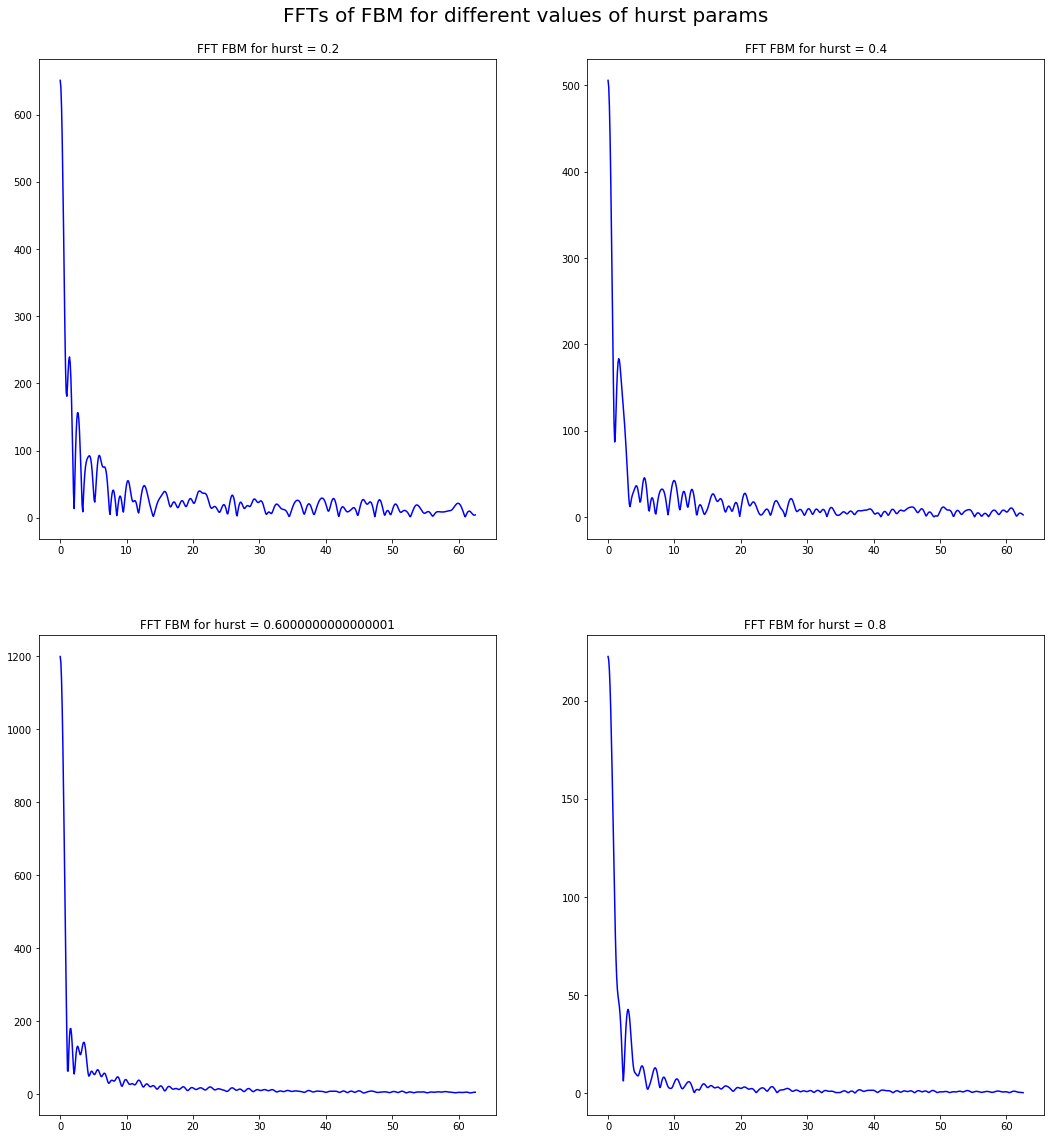

In [37]:
def plot_fft(fbm_vals,hurst,subplot_index=111):
    samp_freq=1000
    NFFT=10*t_samp.shape[0]
    zp_arr=np.append(np.array(fbm_vals),np.zeros(NFFT-len(fbm_vals)))
    fbm_freq=fft(zp_arr,NFFT)
    disc_w=np.linspace(0,samp_freq/16,NFFT//16)
    ax= fig.add_subplot(subplot_index)
    ax.set_title("FFT FBM for hurst = "+str(hurst))
    ax.plot(disc_w,abs(fbm_freq[0:NFFT//16]),'b')
    return fbm_freq[0:NFFT//2]

plt.rcParams['figure.figsize'] = (18, 18)
fig = plt.figure()
fig.tight_layout()
fig.subplots_adjust(top=0.94)
plt.suptitle("FFTs of FBM for different values of hurst params",fontsize=20)
subplot_list=[221,222,223,224]
freq_fbm_samps=[]
for i in range(len(fbm_samps)): 
    freq_fbm_samps.append(plot_fft(fbm_samps[i],0.2*(i+1),subplot_list[i]))
plt.show()
